In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule, FaultModule, MeasurementModule, RegulatoryControlModule, SupervisoryControlModule, MaintenanceModule
import inspect
import pprint
import pandas as pd
import time as real_time

In [2]:
# Repeatable results
np.random.seed(85)

In [3]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [4]:
# Maintenance parameters
pprint.pprint(r)

{'Case': 1,
 'MaintenanceCycle': ['All'],
 'MinimumShutDownTime': 0,
 'NextPlannedShut': 604800,
 'PlannedMaintenancePeriod': 604800,
 'PlannedShuts': 0,
 'Running': {'Csp': 0.3, 'levelInterlock': 3},
 'ShutType': 'Initial Startup',
 'Shutdown': {'levelThreshold': 0.001},
 'Startup': {'levelThreshold': 1, 'time': [0]},
 'components': {'C': {'check_duration': 7200,
                      'faultFlag': False,
                      'replace_duration': 14400,
                      'type': 'sensor'},
                'C0': {'check_duration': 7200,
                       'faultFlag': False,
                       'replace_duration': 14400,
                       'type': 'sensor'},
                'F': {'check_duration': 7200,
                      'faultFlag': False,
                      'replace_duration': 14400,
                      'type': 'sensor'},
                'F0': {'check_duration': 7200,
                       'faultFlag': False,
                       'replace_duration': 14400,
 

In [5]:
# Maintenance module
print(inspect.getsource(MaintenanceModule))

def MaintenanceModule(r, f, t):
    # Set duration of shutdown
    r["ShutDownTime"] = r["MinimumShutDownTime"]

    # Cycle over all components to identify components requiring replacement
    # and to determine total shutdown time
    for key in r["components"]["fields"]:
        # Check flagged components OR check for component-type planned maintenance OR check for maintaining all
        if r["components"][key]["faultFlag"] or r["components"][key]["type"]==r["ShutType"] or r["ShutType"]=="All": 
            # Add the time taken to check the component to the shutdown time
            r["ShutDownTime"] += r["components"][key]["check_duration"]

            # Replace faulty components
            if f[key]["state"]!="none":
                f[key]["state"] = "none" # reset fault state
                # Reset drift, if applicable
                if f[key]["fault_type"]=="drift":
                    f[key]["drift"] = 0
                f[key]["runtime"] = 0 # reset runtime
               

In [6]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [7]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (s)', 
                'F0', 'FW', 'F','L',
                'Regime']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']: # necessary while loop, since shuts can skip forward in time
    # Update time (check for jumps from maintenance)
    t['tvector'][t['i']+1] = t['tvector'][t['i']] + t['deltat']
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    # Supervisory control module
    r = SupervisoryControlModule(r, m, y, t)
    # Maintenance module
    if r['regime']=='Shut':
        r, f, t = MaintenanceModule(r, f, t) # t['i'] updated during maintenance
    # Regulatory control module
    u = RegulatoryControlModule(u, y, r)
    # Process module
    x = ProcessModule(p, u, d_now, x, f, t)
    # Measurement module
    y = MeasurementModule(y, x, d_now, f)

    # Update results
    results[t['i'], :] = [t['tvector'][t['i']]/(3600*24),
                          x['F0'], 
                          x['FW'],
                          x['F'], 
                          x['L'],
                          r['regimeNumeric']]
    # Display progress in percent time
    if t['tvector'][t['i']] % (2*24*3600) == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')


Simulation progress:
0.00%
7.14%
14.29%
21.43%
28.57%
35.71%
42.86%
50.00%
57.14%
64.29%
71.43%
78.57%
85.71%
92.86%
Done! Simulation duration: 1.2 seconds.


In [8]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (s)', inplace=True)

array([<Axes: xlabel='Time (s)'>, <Axes: xlabel='Time (s)'>,
       <Axes: xlabel='Time (s)'>, <Axes: xlabel='Time (s)'>,
       <Axes: xlabel='Time (s)'>], dtype=object)

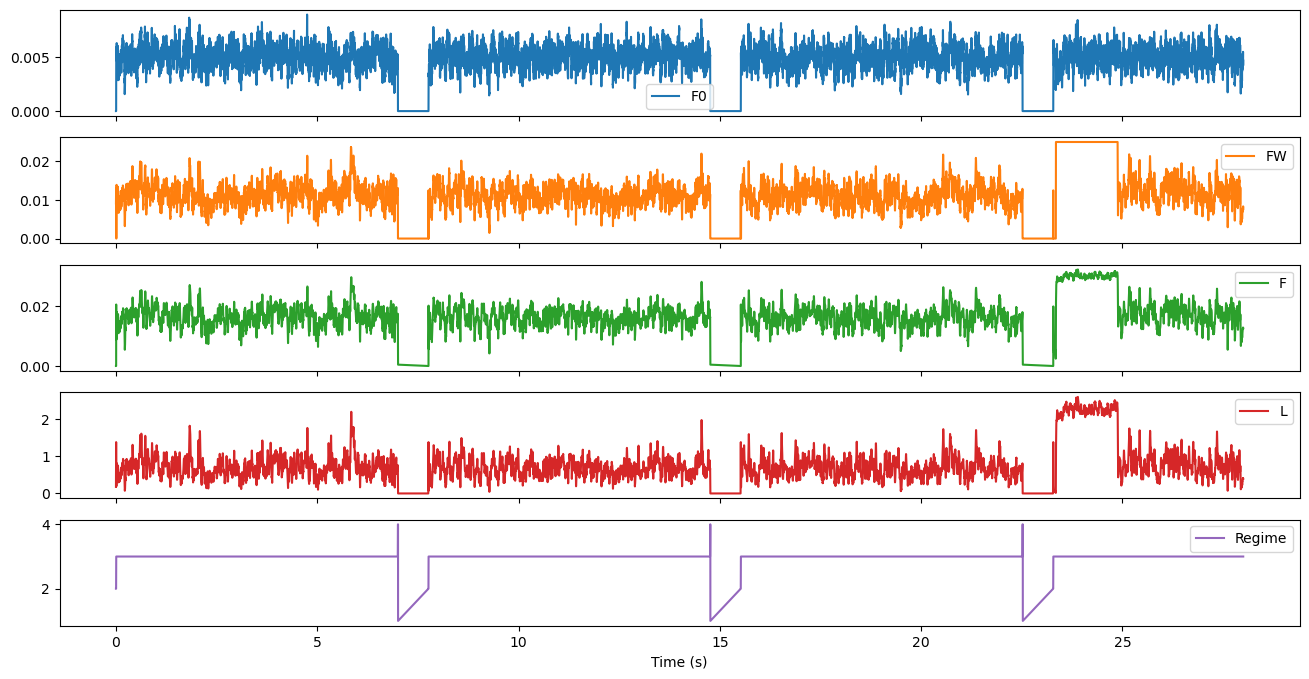

In [9]:
# Plot
startInd = 0
endInd = len(df)
plot_list = ['F0','FW','F','L','Regime']
df[plot_list].iloc[startInd:endInd].plot(subplots=True, figsize=(16,8))